## Stokes Flow in Periodic Channel with Robin boundary.

In [40]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from boundary_solvers.gauss_grid_2d import TrapezGrid
from hmm.stokes import *
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib
from scipy.interpolate import interp1d
from architecture.session import fno_ver3, fno_ver4, fno_ver1, fno_ver2, egeofno_ver2, svdfno_ver2, svdfno_ver1, svdfno_ver3, egeofno_ver5, svdfno_ver4
import torch

#matplotlib.rcParams['text.usetex'] = False


#net_dir = "/mnt/data0/emastr/article_training_nodecay/"
net_dir = "/mnt/data0/emastr/article_training_lowline/"
MESH_PATH = "/home/emastr/deep-micro-slip-model/data/mesh/"
figures_dir = "/home/emastr/deep-micro-slip-model/data/figures/"
simulation_dir = "/home/emastr/deep-micro-slip-model/data/stokes_fenics/"
#data_dir = "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data_big_clean.torch"
run_dir = "/home/emastr/deep-micro-slip-model/data/reference_2/"

#pretty_pyplot_layout()

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

In [41]:
i = 41-16#2+16*0#+16#2+16#2+16*3# 2+16#41 # 38 #41 #35 #11 #38 #22 
data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
data_0, _ = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")

data_big_domain = data
dom = data.dom
eval_pos = info["eval_pos"]
eps = info["eps"]
nper = info["nper"]
Lx = info["Lx"]
bbox = info["bbox"]
Uc = info['Uc']
Vc = info['Vc']
Uyc = info['Uyc']

x = np.linspace(bbox[0][0],bbox[0][1],Uc.shape[0])
y = np.linspace(bbox[1][0],bbox[1][1],Uc.shape[1])
X,Y = np.meshgrid(x,y)

pwlerp = PiecewiseInterp2D(x, y, Uc)
from architecture.session import egeofno_ver3, egeofno_ver2, egeofno_ver1, svdfno_ver2, svdfno_ver1, svdfno_ver3
pwlerp_dy = PiecewiseInterp2D(x, y, Uyc)
pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)
print(eps)

0.004641588833612777


### Load Network for evaluation

In [42]:
device = "cpu" # "cuda:0"
num_pts = 256
#net, net_settings = get_net(f"{net_dir}fnoskip_big_data_{40000}.Torch", 256, "cpu", "float")
net_type = 0# 0: egeofno, 1: svdfno, 2: fno_vanilla
# net_type 0 works well

if net_type == 0:
    net = egeofno_ver3(device=device)
    net_data = torch.load(f"{net_dir}fno_ver3_seed0_40000.Torch", map_location=torch.device(device))
elif net_type == 1:
    net = svdfno_ver2(device=device)
    net_data = torch.load(f"{net_dir}svdfno_ver2_seed0_40000.Torch", map_location=torch.device(device))
else:
    net = fno_ver4(device=device)
    net_data = torch.load(f"{net_dir}fno_vanilla_ver4_seed0_15000.Torch", map_location=torch.device(device))

net.load_state_dict(net_data["state dict"])
net_settings =  {"num_pts": num_pts, \
                 "input_features": net_data["settings"]["input_features"], \
                 "output_features": net_data["settings"]["output_features"],\
                 "device": device, "dtype": torch.float}
#print(net_settings["input_features"])
print(net_data["settings"]["output_features"])

['rt', 'rn', 'drt_norm', 'drn_norm']


## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

StokesData(f=<function StokesData.load_from_matlab.<locals>.<lambda> at 0x7fde9a442de0>, df=<function StokesData.load_from_matlab.<locals>.<lambda> at 0x7fde9a442d40>, ddf=<function StokesData.load_from_matlab.<locals>.<lambda> at 0x7fde9a4402c0>, g=<function StokesData.load_from_matlab.<locals>.<lambda> at 0x7fde9a442520>, dom=[[-1.0, 1.0], [0.001392476650083833, 0.5]], width=2.0, height=0.49860752334991615)


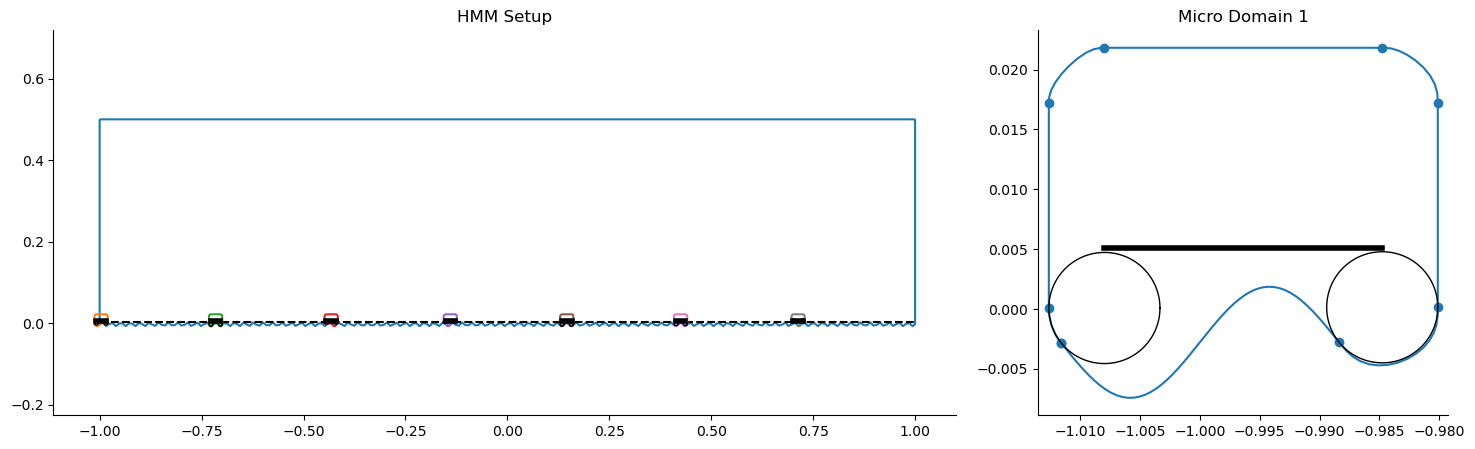

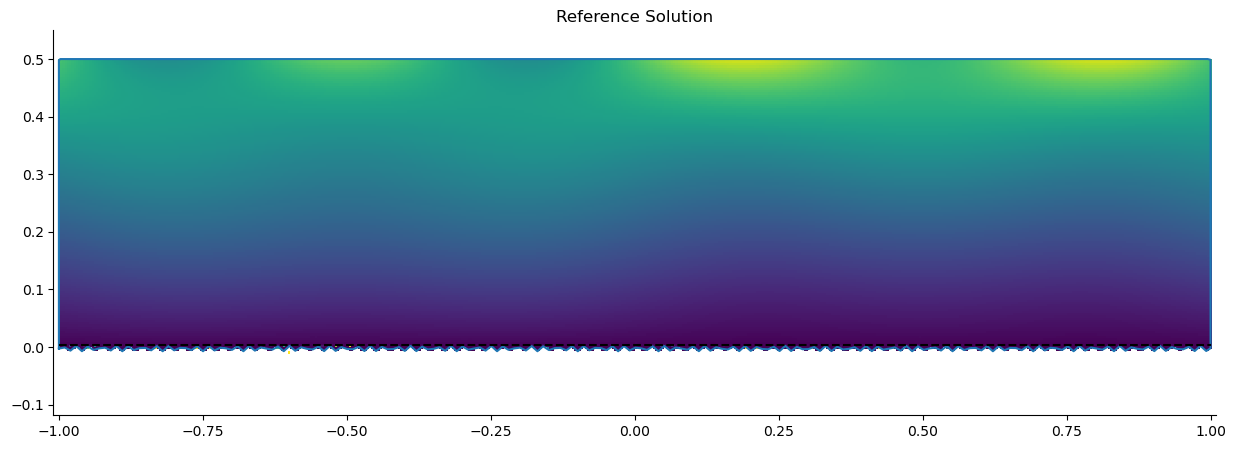

In [43]:
logger = EventTracker() # Log time

tol = 1e-10
xDim = 51
yDim = 51
nMic = 7#7 #freq_g*2+1#2*(round(Lx/(30*eps)) // 2) + 1 # 15 # 15 #nMic*2 +1
yDim_reduce = 15#51
xDim_reduce = 15#51
width = 5*eps #5*eps #3
height = width*0.8 #3
n_refine = 0
linePos = 0.1

#################
# Macro problem
#################
print(data)
data.dom = [dom[0], [linePos*height+dom[1][0], dom[1][1]]] # Make sure line is bottom of domain

# Mean
#macro = StokesMacProb(data, lambda x, a: lambda y: np.mean(a)*np.ones_like(y))
#macro_0 = StokesMacProb(data_0, lambda x,a: lambda y: np.mean(a)*np.ones_like(y))
      
# FFT                  
macro = StokesMacProb(data, lambda x, a: fft_interp(x, a, dom=dom[0]))
macro_0 = StokesMacProb(data_0, lambda x, a: fft_interp(x, a, dom=dom[0])) # For comparison
###################
# Micro problems
###################


#data.dom = [dom[0], [linePos*height, dom[1][1]]]
#xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
xPos = np.linspace(dom[0][0], dom[0][1], nMic+1)[1:] - width/2 - Lx / nMic
micros = [StokesMicProb(data, x, width, height, linePos=linePos, deg_project=8, logger=logger, 
                        n_refine=n_refine, xDim_reduce=xDim_reduce, yDim_reduce=yDim_reduce) for x in xPos]

###################
# Hmm problem.
conv_checker = ConvergenceChecker(macro, micros, tol=tol)
hmm_prob = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)

###################
## PLOT ##
plt.figure(figsize=(18,5))


plt.subplot2grid((1, 3), (0, 0), 1, 2)
plt.title("HMM Setup")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_top_right_axes(plt.gca())

plt.subplot2grid((1, 3), (0, 2), 1, 1)
plt.title("Micro Domain 1")
micros[0].plot(plt.gca(), showsegments=True)
plt.axis("equal")
remove_top_right_axes(plt.gca())

# Plot

vmin, vmax= 0, .7
plt.figure(figsize=(15,5))
plt.title("Reference Solution")
plt.pcolormesh(X, Y, Uc, vmin=vmin, vmax=vmax)
data.plot(plt.gca(), npts=800)
plt.axis("equal")
remove_top_right_axes(plt.gca())
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])



## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [44]:
macro_solver = MacroSolver(xDim, yDim, tol=tol, logger=logger)
macro_solver_0 = MacroSolver(xDim, yDim, tol=tol)

print("Deep precomputing...")
deep_micro_solvers = [DeepMicroSolver(m, net, net_settings, logger=logger, tol=tol) for m in micros]

class CountCallback():
    def __init__(self):
        self.count = 0
    def __call__(self, *args):
        self.count += 1
counters = [CountCallback() for m in micros]
    
print("Classic precomputing...")
micro_solvers = [MicroSolver(m, logger=logger, tol=tol, callback=c) for m, c in zip(micros, counters)]
print("Done")

deep_hmm_solver = IterativeHMMSolver(macro_solver, deep_micro_solvers)
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)

class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(0,1,self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
        self.micro_errors = []
    
    def __call__(self, it, macro_sol, micro_sols):
        errors = []
        for deep_micro, micro, prob in zip(deep_micro_solvers, micro_solvers, micros):
            deep_sol = deep_micro.solve(prob)
            sol = micro.solve(prob)
            errors.append(np.abs((deep_sol.alpha - sol.alpha) / sol.alpha))
            #r_true, _ = micro.geom.precompute_line_avg(derivative=0)
            #t1, _ = micro.geom.grid.get_grid_and_weights()
            #r_true_t = interp1d(t1, r_true, kind="cubic")(micro.t)
            #errors.append(np.linalg.norm(micro.r - r_true_t)/np.linalg.norm(r_true_t))
        self.micro_errors.append(errors)
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
       
debug_cb = Callback(macro)

print([c.count for c in counters])

Deep precomputing...
Classic precomputing...
Done
[24, 27, 22, 20, 29, 26, 19]


error in r: 7.63e-02, in dr: 7.05e-02
error in r: 3.81e-02, in dr: 1.51e-01
error in r: 3.39e-02, in dr: 6.03e-02
error in r: 3.03e-02, in dr: 6.96e-02
error in r: 4.20e-02, in dr: 9.37e-02
error in r: 3.42e-02, in dr: 1.56e-01
error in r: 5.29e-02, in dr: 7.46e-02


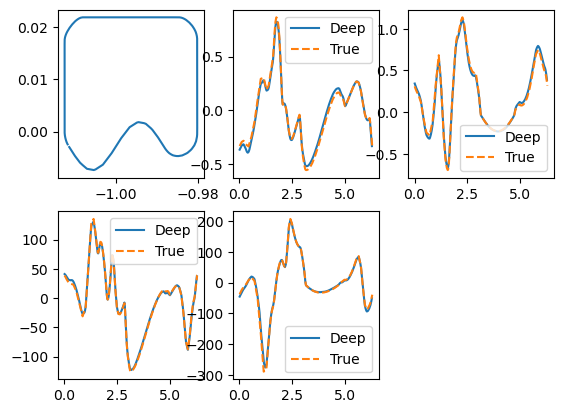

In [45]:
def interp_periodic(t, y, tval):
    t = np.concatenate([[t[-1]-np.pi*2], t, [t[0] + np.pi*2]])
    y = np.concatenate([[y[-1]], y, [y[0]]])
    return interp1d(t, y, kind="cubic")(tval)

num_mic = len(micro_solvers)
sqrt_num_mic = int(np.ceil(num_mic**0.5))
for i, (s, self) in enumerate(zip(micro_solvers, deep_micro_solvers)):
    #print(list(ds.__dict__.keys()))
    self.r_true, self.avg_true = self.geom.precompute_line_avg(derivative=0)
    self.dr_true, self.davg_true = self.geom.precompute_line_avg(derivative=1)
    t1, _ = self.geom.grid.get_grid_and_weights()
    r_true_t = interp_periodic(t1, self.r_true, self.t)
    dr_true_t = interp_periodic(t1, self.dr_true, self.t)
    
    #plt.plot(self.t, r_true_t)
    #plt.plot(self.t, self.r)
    
    
    #plt.figure(1, figsize=(7,15))
    
    #plt.subplot(2*sqrt_num_mic, sqrt_num_mic, i+1)
    #plt.plot(self.t, np.abs(r_true_t))
    #plt.plot(self.t, np.abs(self.r), '--')
    #plt.plot(self.t, np.abs(self.r - r_true_t), ':')
    
    #plt.subplot(2*sqrt_num_mic, sqrt_num_mic, sqrt_num_mic**2 + i + 1)
    #plt.plot(self.t, np.abs(dr_true_t))
    #plt.plot(self.t, np.abs(self.dr), '--')
    #plt.plot(self.t, np.abs(self.dr - dr_true_t), ':')
    print(f"error in r: {np.linalg.norm(self.r - r_true_t)/np.linalg.norm(r_true_t):.2e}, " +\
           f"in dr: {np.linalg.norm(self.dr - dr_true_t)/np.linalg.norm(dr_true_t):.2e}")
#plt.plot(ds.dr[::2].imag)
#lt.plot(ds.dr_true.imag)
#deep_micro_solvers[0].plot()  

for i in range(1):#len(micro_solvers)):
    plt.figure()
    deep_micro_solvers[i].plot()

In [46]:
macro_guess = macro_solver_0.solve(macro_0)

print("Deep HMM Solver...")
(deep_macro_sol, deep_micro_sols) = deep_hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=20, tol=tol, logger=logger)
print("\nDone")

deep_diff = debug_cb.diff
debug_cb.diff = []
debug_cb.micro_errors = []

print("Classic HMM Solver...")
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=20, tol=tol, logger=logger)
print("\nDone")





Deep HMM Solver...
Step 19/20
Done
Classic HMM Solver...
Step 19/20
Done


### Convergence and computation time

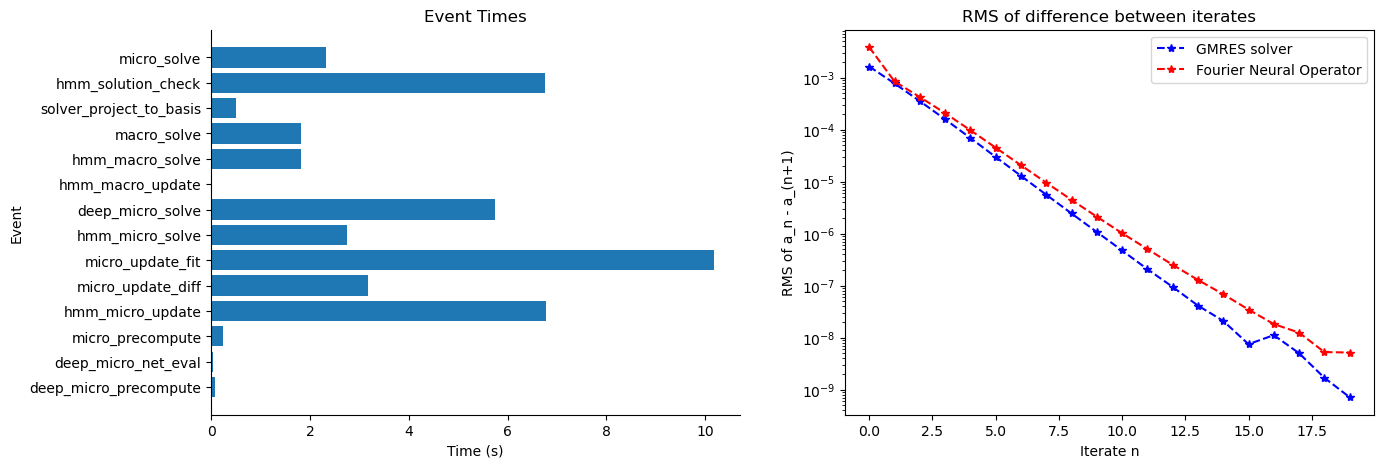

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.title("RMS of difference between iterates")
plt.semilogy(debug_cb.diff, 'b*--', label='GMRES solver')
plt.semilogy(deep_diff, 'r*--', label='Fourier Neural Operator')

plt.legend()
plt.xlabel("Iterate n")
plt.ylabel("RMS of a_n - a_(n+1)")

plt.subplot(121)
logger.barplot_logs(plt.gca())


## Accuracy
We use the reference solver data to construct a piecewise linear interpolation. Also, the micro data is used to construct a set of full solutions to the velocity field in the micro problems for visualisation purposes.

deep: 0.02170
naive: 0.26569
smooth: 0.03806


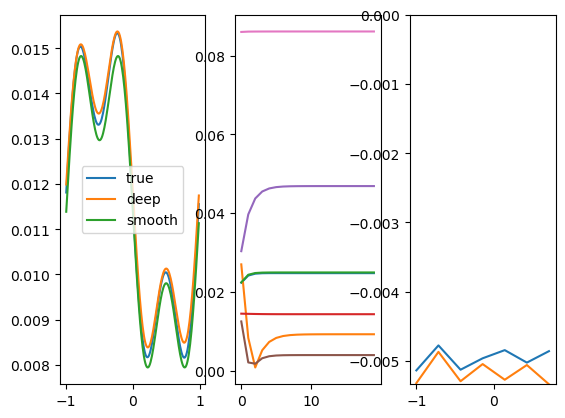

<Figure size 640x480 with 0 Axes>

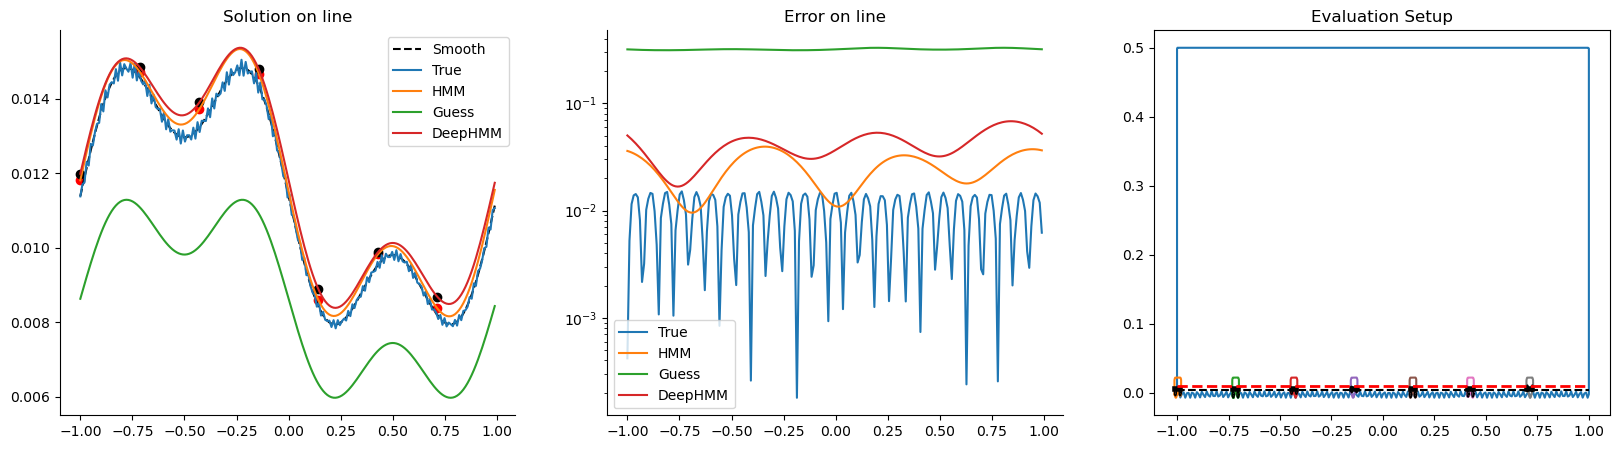

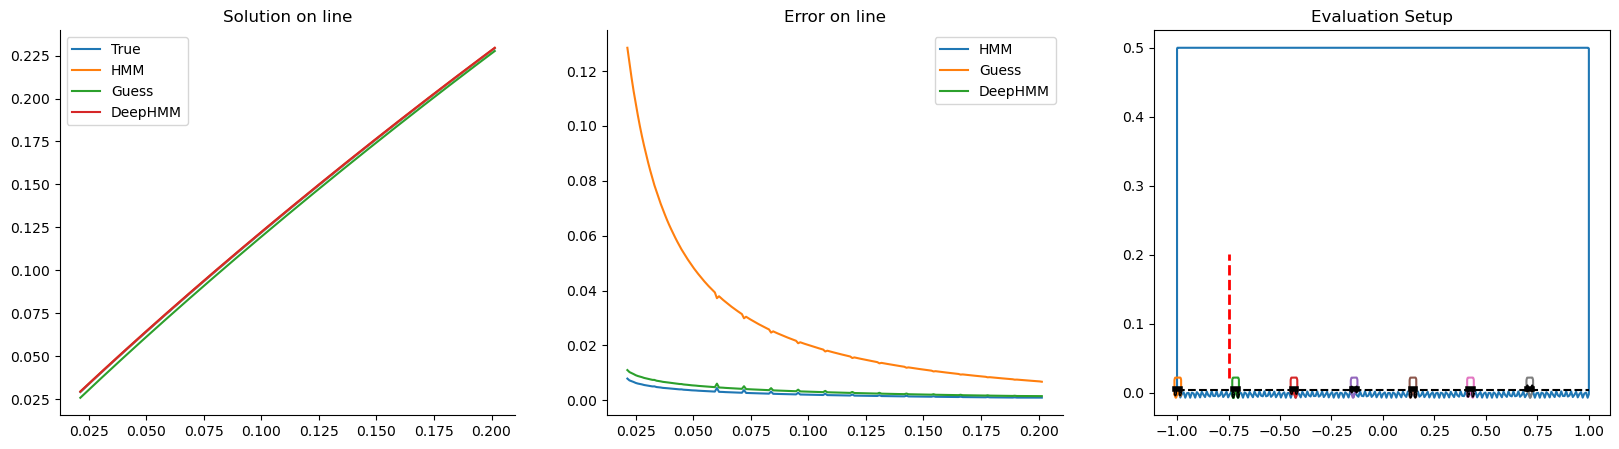

In [48]:
macro_guess = macro_solver.solve(macro_0)


def error(x, y):
    #return np.linalg.norm(x - y) / np.linalg.norm(x)
    return np.max(np.abs(x-y))/np.max(np.abs(x))

# plot a line at y = 0.03
xval = np.linspace(dom[0][0],dom[0][1], 200)[:-1]
yval = np.ones_like(xval)*0.01
basis = ScaleShiftedBasis.fromFunctionInDomain(lambda x: pwlerp(x,yval), dom[0], FourBasis, dim=len(yval)).change_dim(nMic*2+1)
smooth = lambda x, y: basis(x)
funcs = [smooth, pwlerp, macro_sol.u, macro_guess.u, deep_macro_sol.u]
title = ["Smooth", "True", "HMM", "Guess", "DeepHMM"]

plt.figure()
plt.subplot(131)
plt.plot(xval, macro_sol.u(xval, yval), label='true')
plt.plot(xval, deep_macro_sol.u(xval, yval), label="deep")
plt.plot(xval, smooth(xval, yval), label="smooth")
plt.legend()

plt.subplot(132)
for i in range(len(micros)):
    plt.plot([debug_cb.micro_errors[j][i] for j in range(len(debug_cb.micro_errors))])
    
plt.subplot(133)
plt.plot([m.x for m in micro_sols], [m.alpha for m in micro_sols])
plt.plot([m.x for m in micro_sols], [m.alpha for m in deep_micro_sols])
plt.ylim([min(m.alpha for m in deep_micro_sols), 0])

print(f"deep: {error(macro_sol.u(xval, yval), deep_macro_sol.u(xval, yval)):.5f}")
print(f"naive: {error(macro_sol.u(xval, yval), macro_guess.u(xval, yval)):.5f}")
print(f"smooth: {error(macro_sol.u(xval, yval), smooth(xval, yval)):.5f}")

# Plot solutions on horizontal line

plt.figure()
plot_line(xval, yval, funcs, title, hmm_prob.plot, axis='x')
plt.subplot(1,3,2)
plt.yscale("log")

plt.subplot(1,3,1)
plt.scatter(xPos+width/2, macro_sol.u(xPos+width/2, yval[0]*np.ones_like(xPos)), color='r')
plt.scatter(xPos+width/2, deep_macro_sol.u(xPos+width/2, yval[0]*np.ones_like(xPos)), color='k')

# plot a vertical line in between the first and second micro problems
funcs.pop(0)
title.pop(0)
yval = np.linspace(dom[1][0]+0.02, dom[1][0] + 0.2, 200)
xval = -0.75*np.ones_like(yval) #0.5*(xPos[nMic//2] + xPos[nMic//2+1]) * np.ones_like(yval)

idx = np.arange(len(xval))
s = 13
r = 9

plot_line(xval[idx % s != r], yval[idx % s != r], funcs, title, hmm_prob.plot, axis='y')
#plot_line(xval, yval, funcs, title, hmm_prob.plot, axis='y')

## Visualisation - 2D plots

/tmp/ipykernel_2870283/3928450057.py:24: RuntimeWarning: invalid value encountered in divide
  return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))


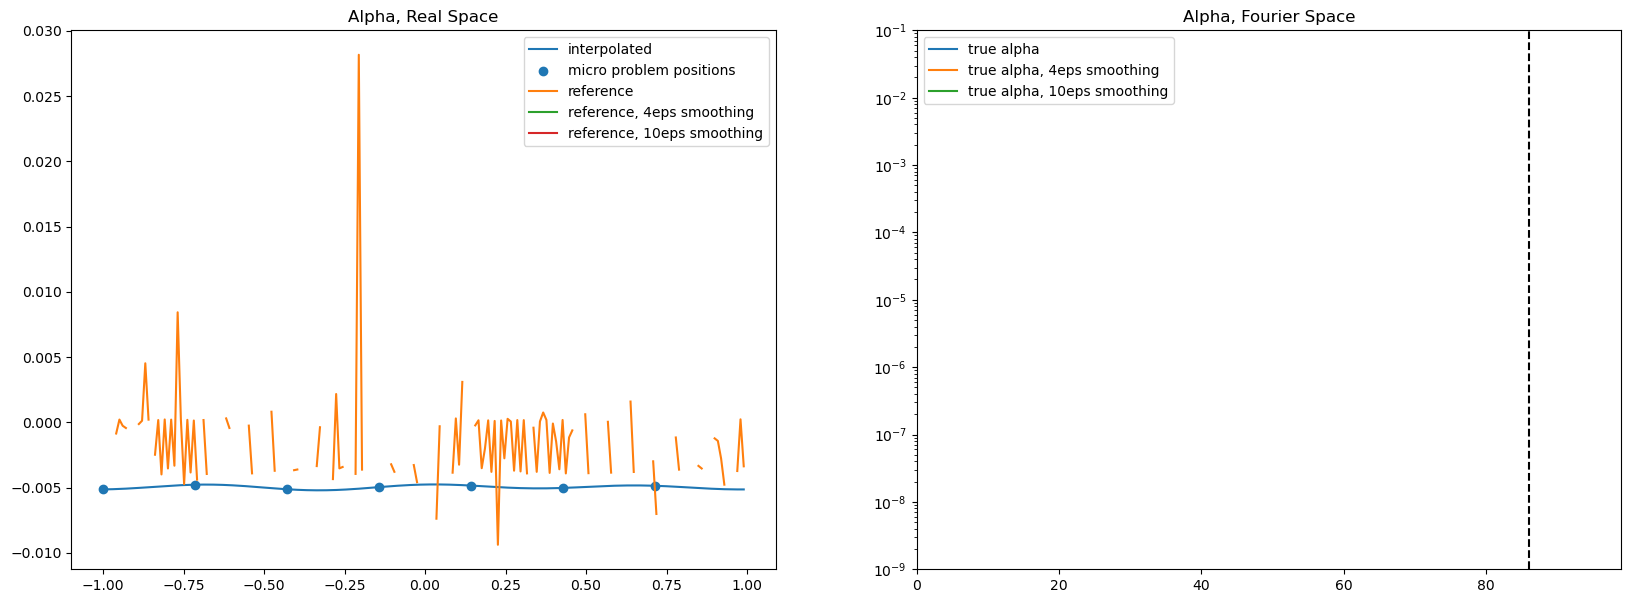

In [49]:
pwlerp_alpha = lambda x: -pwlerp(x, np.ones_like(x)*eval_pos) / pwlerp_dy(x, np.ones_like(x)*eval_pos)
pwlerp_alpha_2 = lambda x: -pwlerp(x, np.ones_like(x)*0.05) / pwlerp_dy(x, np.ones_like(x)*0.05)


x = np.linspace(dom[0][0],dom[0][1],200)[:-1]
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])

# Estimating alpha
dy = 0.01
y = 0.045*np.ones_like(x)
#a_apx = eval_pos/0.045/10*(pwlerp(x, y+dy)-pwlerp(x, y))/(pwlerp(x, y))-0.01
#_apx = np.sin(x * np.pi * 2)

a_apx = pwlerp_alpha(x)

basis = FourBasis(FourBasis._interpolate(pwlerp_alpha(x)))
freq = np.imag(basis._freq(basis.dim))
ks = freq / (2 * np.pi)
coef = basis.get_coef()

def sq_filt(omega, a):
    return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))
filt = lambda a: sq_filt(freq, a)
filtered1 = filt(4*eps) * coef
filtered2 = filt(10*eps) * coef

scale, shift  = ScaleShiftedBasis._domain_to_scale_shift(FourBasis._domain(), dom[0])
filtered1_inv = ScaleShiftedBasis(FourBasis(filtered1), scale, shift)
filtered2_inv = ScaleShiftedBasis(FourBasis(filtered2), scale, shift)
truncated_inv = filtered1_inv.change_dim(nMic)

plt.figure(figsize=(20,7))

plt.subplot(121)
plt.title("Alpha, Real Space")
plt.plot(x, a, label="interpolated")
plt.scatter(xm, am, label="micro problem positions")
plt.plot(x, a_apx, label="reference")
filtered1_inv.plot(plt.gca(), dim=200, label="reference, 4eps smoothing")
filtered2_inv.plot(plt.gca(), dim=200, label="reference, 10eps smoothing")
plt.legend()

plt.subplot(122)
plt.title("Alpha, Fourier Space")
plt.semilogy(ks, np.abs(coef), label="true alpha")
#plt.semilogy(freq, filt(eps) * coef)
plt.semilogy(ks, np.abs(filtered1), label="true alpha, 4eps smoothing")

plt.semilogy(ks, np.abs(filtered2), label="true alpha, 10eps smoothing")
# plot vertical lines at frequencies corresponding to eps
plt.plot([nper, nper], [1e-9, 1e-1], 'k--')
plt.legend()
plt.ylim([1e-9, 1e-1])
plt.xlim([0, max(ks)])

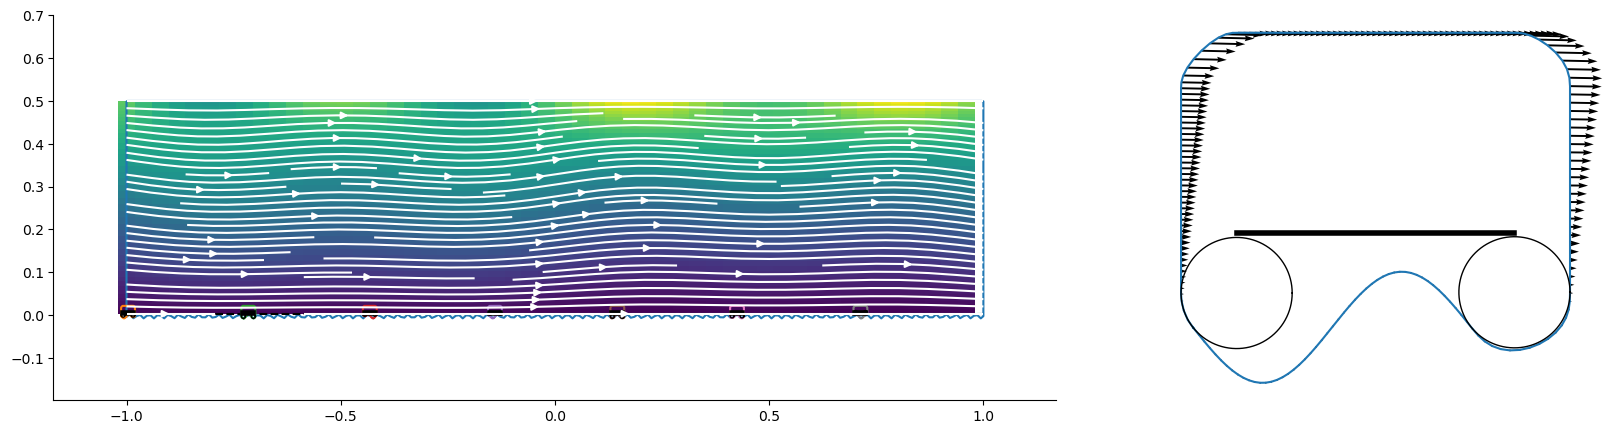

In [50]:
from util.basis_scaled import ScaleShiftedBasis
plt.figure(figsize=(20,5))

plt.subplot2grid((1, 3), (0, 0), 1, 2)
plt.axis("equal")
hmm_prob.plot(plt.gca())
macro_sol.u.plot(plt.gca())
macro_sol.plot_stream(plt.gca(), color="white")
w = dom[0][1] - dom[0][0]
plt.xlim([dom[0][0]-0.1*w, dom[0][1]+0.1*w])
plt.ylim([dom[1][0]-0.1*w, dom[1][1]+0.1*w])
remove_top_right_axes(plt.gca())

plt.subplot2grid((1, 3), (0, 2), 1, 1)
micros[0].plot(plt.gca())
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")
remove_axes(plt.gca())

/tmp/ipykernel_2870283/4096828511.py:19: RuntimeWarning: invalid value encountered in divide
  return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))


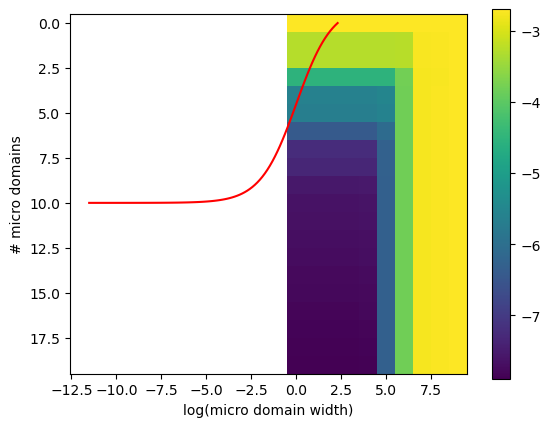

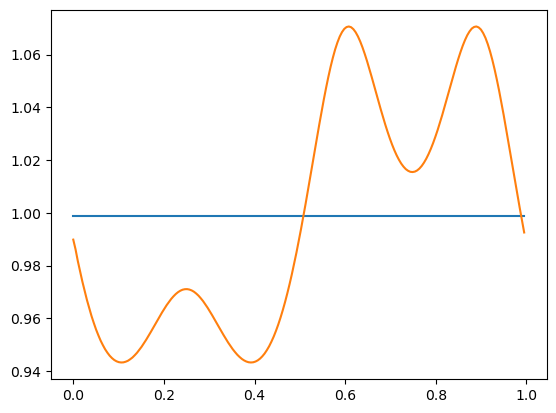

In [51]:
from util.basis_scaled import ScaleShiftedBasis

x = np.linspace(dom[0][0],dom[0][1],401)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])

# Estimating alpha
dy = 0.01
y = 0.045*np.ones_like(x)
a_apx = (pwlerp(x, y+dy)-pwlerp(x, y))/pwlerp(x, y)
a_apx = a_apx / np.mean(a_apx**2)**0.5

basis = FourBasis(FourBasis._interpolate(a_apx))
freq = np.imag(basis._freq(basis.dim))
coef = basis.get_coef()

def sq_filt(omega, a):
    return np.where(np.abs(omega)<1e-3, np.ones_like(omega), np.sin(omega * a) / (omega * a))
filt = lambda a: sq_filt(freq, a)

hs = np.logspace(-5, 1, 10)
#hs = np.linspace(0.1, 4, 10)
dims = np.array([2 * m + 1 for m in range(0, 20)])
mse = []
for d in dims:
    mse_sub = []
    for h in hs:
        filtered = filt(h) * coef
        filt_basis = FourBasis(filtered)
        trunc = filt_basis.change_dim(d).change_dim(basis.dim)
        mse_sub.append(np.mean(np.abs((trunc - basis).eval_grid())**2))
        #mse_sub.append(np.mean(np.abs(trunc.coef - basis.coef)**2))
    mse.append(mse_sub)
H, D = np.meshgrid(hs, dims)
logH = np.log(H)
c = 0.001
c2 = 11
hbig = np.logspace(-5, 1, 100)

plt.figure()
#plt.pcolormesh(logH, D, np.log10(np.array(mse))) # + c * H * D
plt.imshow(np.log10(np.array(mse))) # + c * H * D
#plt.plot(np.log(hbig), c2/(hbig+1)-1, 'red')
plt.plot(np.log(hbig), c2/(hbig+1)-1, 'red')
plt.colorbar()
plt.xlabel("log(micro domain width)")
plt.ylabel("# micro domains")

plt.figure()
trunc.plot(plt.gca(), 200)
basis.plot(plt.gca(), 200)

In [52]:
xhd = np.linspace(dom[0][0],dom[0][1], Nx)
yhd = np.linspace(dom[1][0]-0.1,dom[1][1], Ny)
Xhd, Yhd = np.meshgrid(xhd, yhd)
Uhd = pwlerp(Xhd.flatten(),Yhd.flatten()).reshape((Ny, Nx))

full_micro_sols = []
for it, m in enumerate(micros):
    prob = StokesDirichletProblem(m.geom, m.condition)
    print(f"solving {it}/{len(micros)}", end="\r")
    prob.solve(verbose=False)
    full_micro_sols.append(prob)

NameError: name 'Nx' is not defined

/tmp/ipykernel_37052/2334165283.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(Xhd, Yhd, Uhd, vmin=vmin, vmax=vmax)#, vmin=0, vmax=0.003)#, vmin=-0.5, vmax=0.5)#, vmin=-0.5, vmax=0.5)
/home/emastr/phd/util/interp.py:53: RuntimeWarning: divide by zero encountered in true_divide
  return (w1 * z0[0] + w2 * z0[1] + w3 * z0[2] + w4 * z0[3]) / (w1 + w2 + w3 + w4)


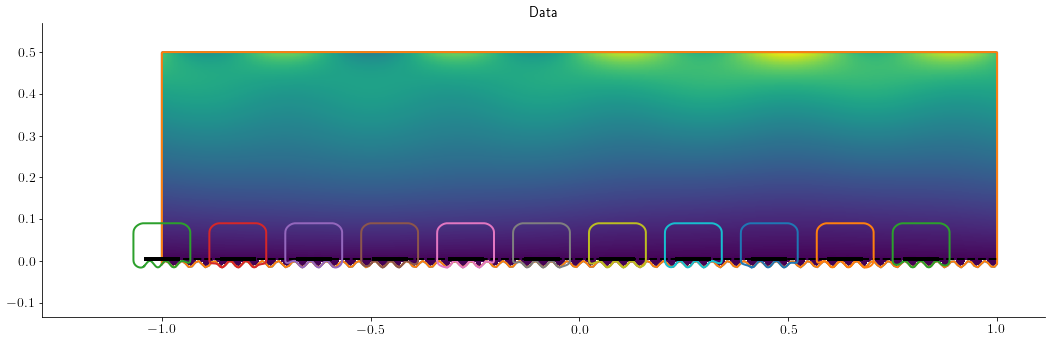

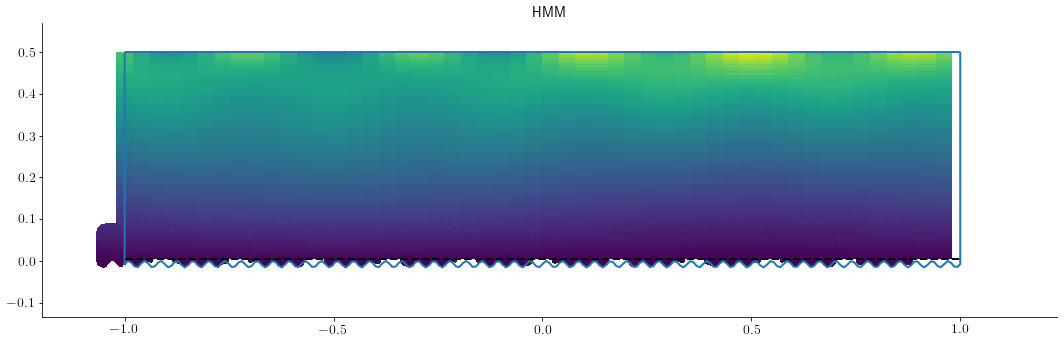

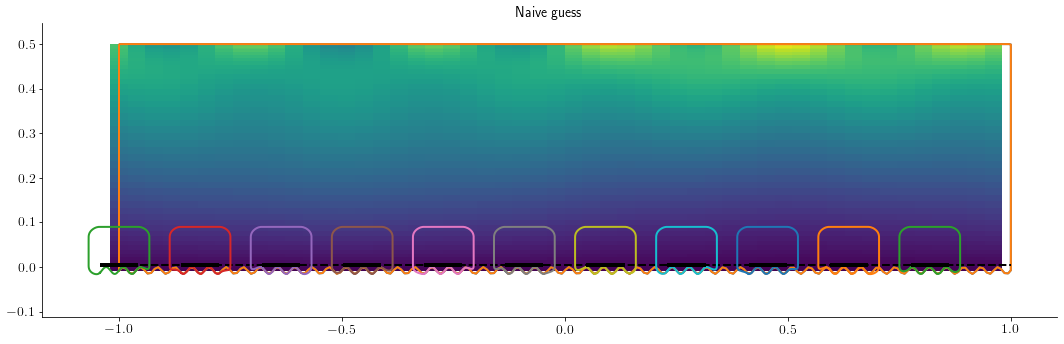

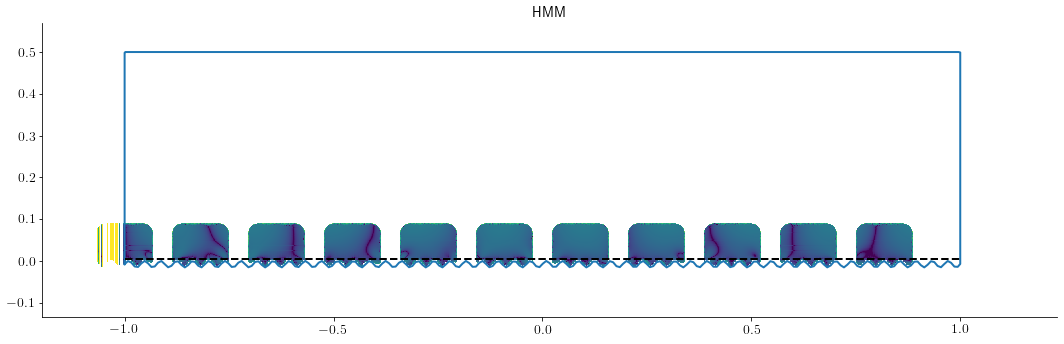

In [ ]:


vmax, vmin = 0.7, 0.

plt.figure(figsize=(15,5))
plt.title("Data")
plt.pcolormesh(Xhd, Yhd, Uhd, vmin=vmin, vmax=vmax)#, vmin=0, vmax=0.003)#, vmin=-0.5, vmax=0.5)#, vmin=-0.5, vmax=0.5)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca())

plt.figure(figsize=(15,5))
plt.title("HMM")
macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
for m, s in zip(micros, full_micro_sols):
    m.geom.plot_field(plt.gca(), lambda z: np.real(s.evaluate(z)), apply_mask=True, vmin=vmin, vmax=vmax)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("Naive guess")
macro_guess.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])
hmm_prob.plot(plt.gca(), color='black', linewidth=1)



plt.figure(figsize=(15,5))
plt.title("HMM")
#macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
data.plot(plt.gca())
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.axis("equal")
plt.ylim([dom[1][0]-0.12, dom[1][1]+0.05])

ev_u = lambda z: macro_sol.u(np.real(z.flatten()), np.imag(z.flatten())).reshape(z.size)
ev_ut = lambda z: pwlerp(np.real(z.flatten()), np.imag(z.flatten())).reshape(z.size)

for m, s in zip(micros, full_micro_sols):
    #m.geom.plot_field(plt.gca(), lambda z: np.log10(np.abs(np.real(s.evaluate(z))-ev_u(z))), 
                      #apply_mask=True, vmin=-3., vmax=0.)
    m.geom.plot_field(plt.gca(), lambda z: np.log10(np.abs(np.real(s.evaluate(z))-ev_ut(z))), 
                      apply_mask=True, vmin=-5., vmax=0.)
#hmm_prob.plot(plt.gca(), color='black', linewidth=1)


Verifying derivatives